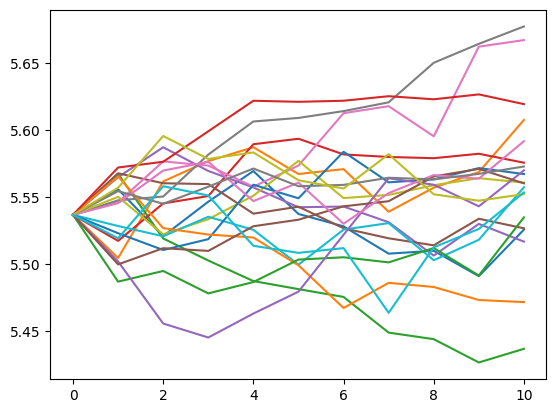

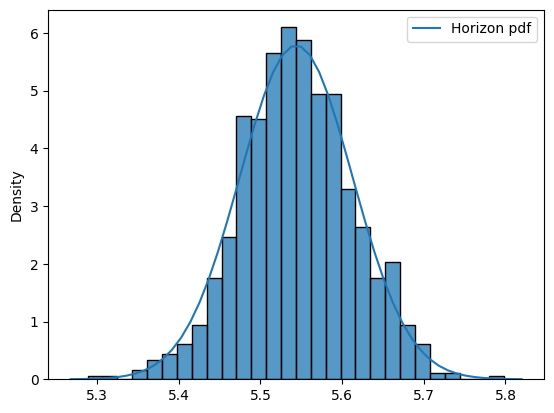

In [12]:
from numpy import arange, average, cov, diff, exp, linspace, log, sqrt, var, zeros
from scipy.stats import norm as normal
from pandas import DataFrame, read_csv, Series, to_datetime
from seaborn import histplot, lineplot
from matplotlib.pyplot import show

x = log(v_stock)  # realized log-value
eps = diff(x)  # realized compounded return (random walk shock)

# fit of parameters normal distributions of shocks
mu_hat = average(eps)  # mean
sigma2_hat = cov(eps, bias=True)  # covariance

########## inputs (you can change them) ##########
t = 10  # horizon (days)
j_bar = 1000  # number of Monte Carlo simulations
step = 1  # time step (days)
##################################################

# current observation
x_0 = x.iloc[-1]

# analytical conditional pdf at horizon
pdf = lambda x : normal.pdf(x, x_0 + mu_hat*t, sqrt(sigma2_hat*t))

# generate Monte Carlo scenarios
x_t = zeros((t + 1, j_bar, 1))
x_t[0, :, :] = x_0
for m in arange(0, int(t/step)):
    eps = normal.rvs(mu_hat*step, sqrt(sigma2_hat*step), j_bar)
    x_t[m + 1, :, :] = x_t[m, :, :] + eps.reshape(j_bar, 1)

############################################### plots ###############################################
# paths
[lineplot(x=linspace(0,t,t+step), y=x_t[:,j].reshape(-1)) for j in range(20)]; show();

grid = linspace(x_0 + mu_hat*t - 4*sqrt(sigma2_hat*t), x_0 + mu_hat*t + 4*sqrt(sigma2_hat*t))
# scen-prob pdf at horizon
lineplot(x=grid, y=pdf(grid), label='Horizon pdf')
histplot(x_t[-1, :].reshape(-1), stat='density'); show();

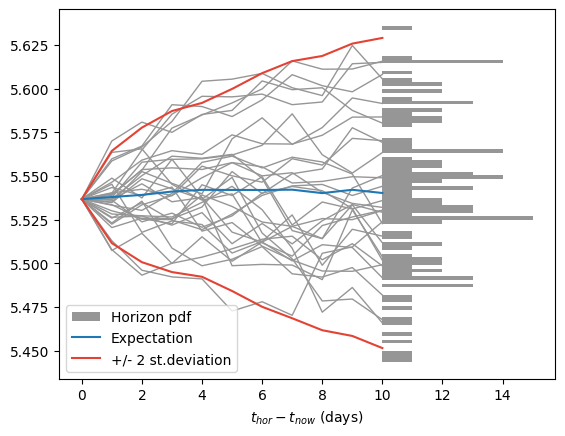

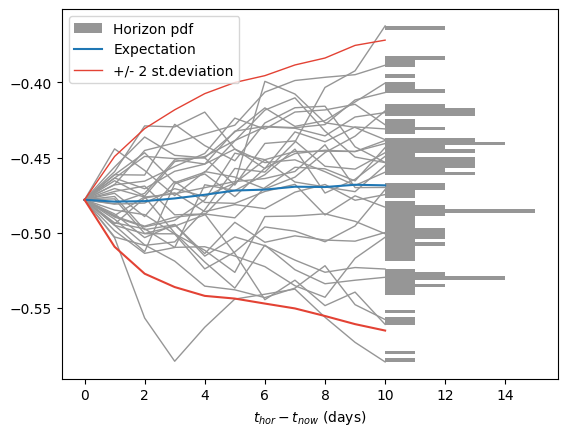

In [1]:
# MC analytical distribution bivariate

from numpy import append, arange, array, average, cov, cumsum, \
                  diff, exp, log, ones, r_, sqrt, sum, zeros
from numpy.random import multivariate_normal
from pandas import DataFrame, read_csv, to_datetime, Series
from seaborn import lineplot
from matplotlib.pyplot import hist, show

########## input (you can change it) ##########
t_bar = 504  # length of time series
###############################################

db_stocks_sp = read_csv('~/Databases/global-databases/equities/db_stocks_SP500/db_stocks_sp.csv', index_col=0, skiprows=[0])
db_stocks_sp = db_stocks_sp.set_index(to_datetime(db_stocks_sp.index))  # set timestamps
v_stock = db_stocks_sp['AMZN']  # stock values
db_fx_data = read_csv('~/Databases/global-databases/currencies/db_fx/data.csv', index_col=0, usecols=['date', 'GBP'],
                      parse_dates=['date']).dropna()
joint_ind =  v_stock.index.intersection(db_fx_data.index)  # joint time index
v_stock = v_stock.loc[joint_ind].tail(t_bar)  # stock values within date range
fx_usd2gbp = db_fx_data.loc[joint_ind].tail(t_bar).values  # USD/GBP exchange rates within date rang


x_stock = log(array(v_stock))  # stock log-values
x_fx = log(fx_usd2gbp).reshape(-1)  # USD/GBP log-exchange rates
########## input (you can change it) ##########
tau_hl = 180  # half-life (days)
###############################################

# exponential decay probabilities
p_tau_hl = exp(-(log(2)/tau_hl)*abs(t_bar - 1 - arange(0, t_bar - 1)))
p_tau_hl = p_tau_hl/sum(p_tau_hl)

# invariants past realizations
eps_stock = diff(x_stock)
eps_fx = diff(x_fx)

# HFP expectation and covariance
mu_hat = average(r_[eps_stock.reshape(1,-1), eps_fx.reshape(1,-1)].reshape((-1, 2)), weights=p_tau_hl, axis=0)
sigma2_hat = cov(r_[eps_stock.reshape(1,-1), eps_fx.reshape(1,-1)].reshape((-1, 2)).T, aweights=p_tau_hl)

########## inputs (you can change them) ##########
j_bar = 100  # number of Monte Carlo simulations
m_bar = 10  # number of monitoring times (days)
##################################################

# Monte Carlo scenarios
x_t_now_t_hor = zeros((j_bar, m_bar + 1, r_[x_stock[-1], x_fx[-1]].shape[0]))
x_t_now_t_hor[:, 0, :] = r_[x_stock[-1], x_fx[-1]]
for m in range(m_bar):
    eps_delta_t_m = multivariate_normal(mu_hat, sigma2_hat, j_bar)
    x_t_now_t_hor[:, m + 1, :] = x_t_now_t_hor[:, m, :] + eps_delta_t_m.reshape(j_bar, r_[x_stock[-1], x_fx[-1]].shape[0])

t_m = append(0, cumsum(ones(m_bar)))  # time steps

# expectation and standard deviation of stock log-values
mu_stock_t_hor = zeros(m_bar + 1)
sigma_stock_t_hor = zeros(m_bar + 1)
for m in range(m_bar + 1):
    mu_stock_t_hor[m] = average(x_t_now_t_hor[:, m, :], axis=0)[0]
    sigma_stock_t_hor[m] = sqrt(cov(x_t_now_t_hor[:, m, :].T)[0, 0])

# expectation and standard deviation of USD/GBP log-exchange rates
mu_fx_t_hor = zeros(m_bar + 1)
sigma_fx_t_hor = zeros(m_bar + 1)
for m in range(m_bar + 1):
    mu_fx_t_hor[m] = average(x_t_now_t_hor[:, m, :], axis=0)[1]
    sigma_fx_t_hor[m] = sqrt(cov(x_t_now_t_hor[:, m, :].T)[1, 1])

######################################################## plots ########################################################
# projection of log-value
for j in range(min(j_bar, 30)):
    lineplot(x=t_m, y=x_t_now_t_hor[j, :, 0], lw=1, color='#969696')
hist(x_t_now_t_hor[:, -1, 0], bins=90, color='#969696', orientation='horizontal', bottom=t_m[-1], label='Horizon pdf')
lineplot(x=t_m, y=mu_stock_t_hor, label='Expectation').set(xlabel=r'$t_{\mathit{hor}}-t_{\mathit{now}}$ (days)')
lineplot(x=t_m, y=mu_stock_t_hor - 2*sigma_stock_t_hor, color='#e34234')
lineplot(x=t_m, y=mu_stock_t_hor + 2*sigma_stock_t_hor, label='+/- 2 st.deviation', color='#e34234'); show();

# projection of currency log-exchange rate
for j in range(min(j_bar, 30)):
    lineplot(x=t_m, y=x_t_now_t_hor[j, :, 1], lw=1, color='#969696')
hist(x_t_now_t_hor[:, -1, 1], bins=90, color='#969696', orientation='horizontal', bottom=t_m[-1], label='Horizon pdf')
lineplot(x=t_m, y=mu_fx_t_hor, label='Expectation').set(xlabel='$t_{\mathit{hor}}-t_{\mathit{now}}$ (days)')
lineplot(x=t_m, y=mu_fx_t_hor - 2*sigma_fx_t_hor, color='#e34234')
lineplot(x=t_m, y=mu_fx_t_hor + 2*sigma_fx_t_hor, label='+/- 2 st.deviation', color='#e34234', lw=1); show();

In [ ]:
# MC copula-marginal distribution forcasting

from numpy import append, arange, average, busday_offset, c_, cov, \
                  datetime64, logical_and, quantile, r_, sqrt, zeros
from scipy.stats import multivariate_t, t
from pandas import DataFrame, concat, read_csv, Series
from seaborn import lineplot
from matplotlib.pyplot import hist, sho

db_calloption_garch = read_csv('~/Databases/temporary-databases/db_calloption_garch.csv')
# fitted parameters of GARCH(1,1) model
a_hat = db_calloption_garch['a'][0]
b_hat = db_calloption_garch['b'][0]
c_hat = db_calloption_garch['c'][0]
mu_hat = db_calloption_garch['mu'][0]
sigma2_hat_t_now = db_calloption_garch['sig2prev'][0]
# last observed values of log underlying
x_t_now = db_calloption_garch['x_tnow'][0]
x_t_now1 = db_calloption_garch['x_tnow-1'][0]

db_calloption_var1 = read_csv('~/Databases/temporary-databases/db_calloption_var1.csv')
# VAR(1) implied volatility surface
x_t_now_sigma = db_calloption_var1.loc[:, db_calloption_var1.columns == 'x_tnow'].values.reshape(-1)
b_hat_var = db_calloption_var1.loc[:, db_calloption_var1.columns != 'x_tnow'].values  # VAR(1) parameter b
db_calloption_epsi_var1 = read_csv('~/Databases/temporary-databases/db_calloption_epsi_var1.csv', 
                                   index_col=0, parse_dates=True)
db_calloption_epsi_garch = read_csv('~/Databases/temporary-databases/db_calloption_epsi_garch.csv', 
                                    index_col=0, parse_dates=True)
# realized garch invariants and implied volatility surface
eps = c_[db_calloption_epsi_garch.values, db_calloption_epsi_var1.values]
i_bar = eps.shape[1]
db_calloption_estimation = read_csv('~/Databases/temporary-databases/db_calloption_estimation.csv')
p = db_calloption_estimation['p'].values  # flexible probabilities
# parameters of t copula
nu = db_calloption_estimation['nu'][0]  # degrees of freedom
# correlation matrix
cr = db_calloption_estimation.loc[:i_bar - 1, logical_and(
     db_calloption_estimation.columns != 'nu', db_calloption_estimation.columns != 'p')]

######### inputs (you can change them) #########
j_bar = 1000  # number of Monte Carlo scenarios
m_bar = 120  # number of monitoring times
################################################

# compute copula-marginal scenarios
eps_j_tm = zeros((j_bar, m_bar, i_bar))
for m in range(m_bar):
    # Student t scenarios
    eps_tilde_proj = multivariate_t.rvs(zeros(i_bar), cr.values, nu, j_bar)
    for i in range(i_bar):
        # compute grades of Student t scenarios (=copula scenarios)
        u_proj = t.cdf(eps_tilde_proj[:, i], nu)
        # feed grades into quantile with flexible probability (=copula-marginal scenarios)
        eps_j_tm[:, m, i] = quantile(eps[:, i], u_proj)

# initialize Monte Carlo paths for risk drivers process
x_t_now_t_hor = zeros((j_bar, m_bar + 1, i_bar))
x_t_now_t_hor[:, 0, :] = r_[x_t_now, x_t_now_sigma]
dx_t_now_t_hor = zeros(j_bar)

# last observed difference of log underlying
dx_t_now_t_hor1 = x_t_now - x_t_now1
for m in range(m_bar):
    # GARCH(1,1) projection for log underlying  
    sigma2_hat_tm = c_hat + b_hat*sigma2_hat_t_now + a_hat*(dx_t_now_t_hor1 - mu_hat)**2
    dx_t_now_t_hor = mu_hat + sqrt(sigma2_hat_tm)*eps_j_tm[:, m, 0]
    # next step value
    x_t_now_t_hor[:, m + 1, 0] = x_t_now_t_hor[:, m, 0] + dx_t_now_t_hor
    dx_t_now_t_hor1 = dx_t_now_t_hor
    # update volatility
    sigma2_hat_t_now = sigma2_hat_tm
    # VAR(1) projection for points of log implied volatility surface
    x_t_now_t_hor[:, m + 1, 1:] = x_t_now_t_hor[:, m, 1:]@b_hat_var.T + eps_j_tm[:, m, 1:]


############### inputs (you can change them) ###############
x_t = 0  # log underlying
x_imp = 10  # log implied volatility for m=0.05 and tau=0.5
############################################################

# log underlying: moments at horizon
mu_x_t_hor = zeros(m_bar + 1)
sigma_x_t_hor = zeros(m_bar + 1)
for m in range(0, m_bar + 1):
    # expectation
    mu_x_t_hor[m] = average(x_t_now_t_hor[:, m, x_t].reshape(-1, 1))
    # standard deviation
    sigma_x_t_hor[m] = sqrt(cov(x_t_now_t_hor[:, m, x_t].reshape(-1, 1).T))

# log implied volatility: moments at horizon
mu_x_imp_t_hor = zeros(m_bar + 1)
sigma_x_imp_t_hor = zeros(m_bar + 1)
for m in range(0, m_bar + 1):
    # expectation
    mu_x_imp_t_hor[m] = average(x_t_now_t_hor[:, m, x_imp].reshape(-1, 1))
    # standard deviation
    sigma_x_imp_t_hor[m] = sqrt(cov(x_t_now_t_hor[:, m, x_imp].reshape(-1, 1).T))
    
########################################################### plots ###########################################################
# scenarios and distribution for log underlying
grid = arange(0, m_bar + 1)
for j in range(min(j_bar, 20)):
    lineplot(x=grid, y=x_t_now_t_hor[j, :, x_t], color='gray');
hist(x_t_now_t_hor[:, -1, x_t], bins=70, bottom=m_bar + 1, color='gray', orientation ='horizontal');
lineplot(x=grid, y=mu_x_t_hor, label='$\\mathbb{E}\{X^{S}\}$');
lineplot(x=grid, y=mu_x_t_hor + 2*sigma_x_t_hor, label='$\\mathbb{E}\{X^{S}\} \\pm \\sigma$', color='r');
lineplot(x=grid, y=mu_x_t_hor - 2*sigma_x_t_hor, color='r').set(xlabel=r'$t_{\mathit{hor}}-t_{\mathit{now}}$(days)'); show();

# scenarios and distribution for log-implied volatility surface with m=0.05 and tau=0.5
for j in range(min(j_bar, 20)):
    lineplot(x=grid, y=x_t_now_t_hor[j, :, x_imp], color='gray')
hist(x=x_t_now_t_hor[:, -1, x_imp], bins=70, bottom=m_bar + 1, color='gray', orientation='horizontal')
lineplot(x=grid, y=mu_x_imp_t_hor, label='$\\mathbb{E}\{X^{\\Sigma}\}$')
lineplot(x=grid, y=mu_x_imp_t_hor + 2*sigma_x_imp_t_hor, label='$\\mathbb{E}\{X^{\\Sigma}\} \\pm \\sigma$', color='r')
lineplot(x=grid, y=mu_x_imp_t_hor - 2*sigma_x_imp_t_hor, color='r').set(xlabel=r'$t_{\mathit{hor}}-t_{\mathit{now}}$ (days)');